This notebook can be open in Google Colab via this [link](https://colab.research.google.com/github/muhammedfadera/DL4EWS-Dartington/blob/master/Intro_to_DL_for_EWS.ipynb)

In [ ]:
import os

if not os.path.exists("DL4EWS-Dartington"):
    !git clone https://github.com/muhammedfadera/DL4EWS-Dartington.git

!pip install statsmodels scipy



In [ ]:
%cd DL4EWS-Dartington

# Hands-on Introduction to Deep Learning for Early Warnings of Tipping Points

1. Introduction to Deep Learning 

2. Deep Learning with PyTorch

3. Learning early warnings of Tipping


## 1. Introduction to Deep Learning 

Deep Learning has arisen over the past few years as an approach to learning and predicting nonlinear systems with minimal assumptions about the system. Deep Learning models are very successfully across various desciplines despite using the same architectures and building blocks. One can attribute this recent success to three key developments

1. Universality/Universal approximators: [Neural Networks(NNs) are universal function approximators](https://en.wikipedia.org/wiki/Universal_approximation_theorem)

2. Abundance of large amount of data

3. Increase in compute/hardware capabilities: The develpment in GPU and TPUs over the past 5/7 years has made it easy to train large deep learning models sometimes on PCs.

In early warnings research, their use was mainly motivated by the fact that critical slowing down based (CSD) indicators does not seem to be present or at least inform of impending transitions in many systems. Additionally, the CSD based indicators do not tell you the nature of the transition about to happen.  


### The Artificial Neuron 
The smallest building block of NNs is the artificial neuron. It takes in input of a given dimension and nonlinearly transforms it into output of a specified dimension. Each artificial neuron has a weight matrix and sometimes a bias/offset term associated which are trainable. Their computation takes the form 

$$y = f(Wx + b)$$

where $W$ and $b$ are the weights and biases respectively, $x$ is the input (either from other artificial neuron or from data) and $b$ is the bias/offset term. The function $f$ is known as the activation function or nonlinearity. Here is a visualisation of a single artificial neuron.

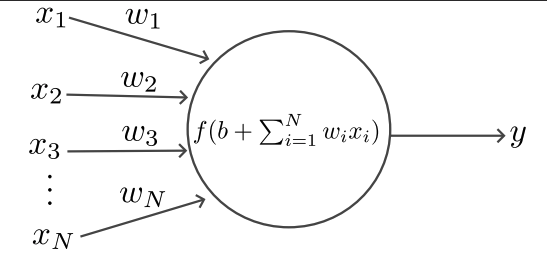

In [7]:
from IPython.display import Image
from matplotlib import pyplot as plt
Image("pictures/perceptron.png")


To build a Deep learning model, these neurons are stacked with the output of one going into the next or sometimes the same neuron using its own output. The particular way this stacking is done is referred to as the architecture of the DL model. 


**stacked artificial neurons forming a feedforward architecture**

<img src="pictures/deep_nn.png" width="500" heig align="center">




Another architecture is the recurrent neural network, which is suitable for general timeseries problems where the present does not depend too much on the far past. Alternatively, if there is a strong dependence on the far past (e.g linking the start and end of a text), Transformers are the state-of-the-art for these type of problems. 

**stacked artificial neurons forming a recurent architecture**

<img src="pictures/recurrent-neural-network.png" width="500" heig align="center">



### Training DL models: Loss or cost function
In order to train your DL model to learn a given task, the network has to be told what `good` performance looks like. This is quantified in what is called a **loss** function. The DL model will then learn to minimise the loss function. For example, if you are learning a continuous variable, you could minimise the mean square error, which is a direct measure of how close your predictions are to the actual value:
$$
L(\theta) = \frac{1}{N}\sum_{i = 1}^N ||y_\text{pred}(X; \theta) - y_\text{actual} ||^2
$$
or if you are learning a probability distribution, the loss could be the negative log-likelihood. 






### Training DL models: Forward and Backward pass
**Forward Pass**: Evaluate your model on data and then compute loss. 

**Backward Pass**: Find the gradient of the loss with respect to all parameters and change your parameters in the direction the function is decreasing (it turns out the negative of the gradient vector is the direction of fastest decrease)
$$
\theta_t = \theta_{t-1} - \delta \nabla_{\theta}L
$$
where $\delta$ is called the learning rate and $\nabla_{\theta}L$ is the gradient of $L$ with respect to the parameters $\theta$. This optimisation procedure is known as stochastic gradient descent (SGD). SGD works by taking small steps in the opposite direction of the gradient (as it turns out, the gradient of a scalar function with vector input is a vector: one for each element of the vector. The best way to think of this vector is that it tells you which direction you should go to increase the function. So to decrease it, you go in the opposite direction.). 


<img src="pictures/gradient_descent_sgd.gif" width="700" heig align="center">



## 2. Deep Learning with PyTorch
PyTorch is an open-source automatic differentiation framework for training Deep Learning models. Because of its flexibility, PyTorch is the go-to autodiff library for research and it is the framework behind ChatGPT, Claude and many other LLMs. Its [numpy](https://numpy.org/)-like syntax makes it an easy transition for those familiar with numpy. There is an R package known as [torch](https://torch.mlverse.org/docs/) with similar syntax. One of the creators of PyTorch described it as serving two purposes

1. A replacement for NumPy to use the power of GPUs and other accelerators.
2. An automatic differentiation library that is useful to implement neural networks.

In this short tutorial, we will introduce the core of PyTorch and build a simple multilayer perceptron to approximate a noisy quasiperiodic function given sparse data.

PyTorch has 4 main components
1. `torch`: A tensor library like numpy but with GPU support. 
1. `torch.autograd`: The automatic differentiation submodule
2. `torch.nn`: Contains most Neural Network architectures and their building blocks such as activation functions, initialisation etc
3. `torch.utils`: submodule for loading data into PyTorch. It also contains a lot of commonly used datasets for Benchmarking Deep Learning models.

The general objects that PyTorch acts on are called `Tensors`. 

### Numpy-like Syntax
PyTorch can do most of what Numpy does (and even more) by replacing the popular prefix `np.` with `torch.`. 

In [1]:
import numpy as np
import torch
import torch.nn as nn

In [2]:
data = [[1, 2], [3, 4]]
# creating tensors from data
x_data = torch.tensor(data)
# creating tensors from a numpy array
data_np = np.array(data, dtype=np.float64)
data_torch = torch.tensor(data_np, dtype=torch.float64)


# some functions in numpy
print(f"Numpy mean: {data_np.mean()}")
print(f"Numpy sum: {data_np.sum()}")
# same functions in pytorch
print(f"PyTorch mean: {data_torch.mean()}")
print(f"PyTorch sum: {data_torch.sum()}")

Numpy mean: 2.5
Numpy sum: 10.0
PyTorch mean: 2.5
PyTorch sum: 10.0


### Device for storing models and their parameters
Unlike Numpy, tensors in PyTorch have a device on which they are stored. The choice of device of which a tensor is stored can vastly affect the perfomance of deep learning models. The most popular choice is GPUs as their structure allows to fast storage and retrieval of tensors. The default device is mostly cpu but this can easily be changed. 

In [ ]:
# check which device is available in order of the fast/most supported to the slowest
device = (
    "cuda" #  Nvidea CUDA framework: most supported but maybe slower than mps if mps is available
    if torch.cuda.is_available() 
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


data_device = data_torch.to(device=device, dtype=torch.float32)


### Custom Layers in PyTorch
PyTorch has a bunch of NN layers and modules in the `torch.nn` module. These includes 

1. `nn.Linear` for representing weight matrices.
2. `nn.Sequential` for chaining layers of neural networks. 
3. `nn.ReLU`, `nn.Tanh()` for activation functions


## 3. Learning early warnings of Tipping

The mathematical theory of early warning has provided researchers from various fields a way to quantify whether a system is closed to tipping, based on the statistics of the systems response to small perturbations. When a system is close to a steady state, it always has natural tendency to go back to the steady state under small perturbations. As a system nears a bifurcation tipping, this ability to recover reduces and the system 

1. takes longer to return to the steady state
2. spend more time in a given part of state space.

This means quantities such as the lag-1 autocorrelation starts to increase close to tipping. However, it has been found that other types of tipping is possible which are not bifurcation induced. This includes rate-induced tipping and noise-induced tipping and there is no critical slowing down theory for example for rate-induced tipping while many complex systems have been shown to undergo rate-induced tipping [1]. Moreover, critical slowing down does not give any indication as to the type of tipping that will occur or the nature of the new state that will emerge once the system tips. 

These are the kinds scenarios where deep learning models excels. Here we will introduce the CNN-LSTM that is the current standard [1, 2] for learning early warning signals of tipping from time series. 



[1] [Huang et al. 2024. "Deep Learning for predicting rate-induced tipping"](https://www.nature.com/articles/s42256-024-00937-0)

[2] [Bury et al. 2021. "Deep Learning for early warning signals of tipping points"](https://www.pnas.org/doi/10.1073/pnas.2106140118?doi=10.1073%2Fpnas.2106140118)



### The CNN-LSTM Architecture
This architecture is composed of two key components: The Convolutional Neural Network (CNN) which learns features and the Long-Short-Term Memory (LSTMs) network is a recurrent neural network which learns the dynamic evolution of these features at time passes. Each CNN feature is parameterise by a weight matrix which slides over the time series and output a weighted combination with the part of the time series it intersects. [Here is a nice visualisation of what convultion does]((https://kowshik24.github.io/convolution-visualizer/)). 



### Example with Predicting a Saddlenode bifurcation

We will be using generated trajectories of two systems. One undergoing a saddlenode bifurcation when the parameter is $0$ and the other has a stable equilibrium for all values of the parameter. Each sequence is of length $1500$ sampled at regular intervals from a sequence of length $4500$, ending at the red line shown on the right. 

<img src="pictures/sn_null_plot.png" width="700"  align="center">

In [ ]:
#% This is similar to Bury et al Architecture 
class CNN_LSTM_TippingClassifier(torch.nn.Module):
    def __init__(self, hidden_size, input_size = 1, output_size = 2, 
                 n_features = 10, seq_length = 1500,
                 kernel_size = 12):
       super(CNN_LSTM_TippingClassifier, self).__init__() 


       self.conv = nn.Sequential(
        #  convolution
        nn.Conv1d(
            in_channels=input_size, out_channels=n_features,
            kernel_size=kernel_size, padding=0, stride=1
        ),
        # dropout with 0.1 probability
        nn.Dropout(0.1),
        # max pool
        nn.MaxPool1d(kernel_size=kernel_size, stride = 1, padding=0)
       )
       moving_window = 2*(kernel_size - 1) 
       n_out = seq_length - moving_window
       self.n_out = n_out
       self.n_features = n_features
       self.input_size = input_size
       self.RNN = nn.LSTM(input_size=n_features, hidden_size=hidden_size, bias=True, 
                          num_layers=2, batch_first=True)
       self.Wout = nn.Linear(in_features=hidden_size*n_out, out_features=output_size)
       with torch.no_grad():
           nn.init.sparse_(self.Wout.weight, sparsity=0.99, std=1/np.sqrt(n_out))
           nn.init.zeros_(self.Wout.bias)
       self.flatten = nn.Flatten()
       self.hidden_size = hidden_size

    def forward(self, X):
        X = self.conv(X)
        X = X.view(-1, self.n_out, self.n_features)
        y_pred, _ = self.RNN(X) # RNN gives two outputs, we want to the first one
        y_pred = torch.softmax(self.Wout(self.flatten(y_pred)), dim = -1)
        return y_pred


In [ ]:
# Data preprocessing
# load data
np.random.seed(16022026)
torch.manual_seed(16022026)
from utilities import *

#! do not run as Lowess smoothing is computationally expensive
filenames = [("X_train_null.txt", "X_test_null.txt"), ("X_train_saddlenode.txt", "X_test_saddlenode.txt")]
class_labels = [0, 1]
X_train, y_train, X_test, y_test = read_X_y_data(filenames, class_labels,
                    detrend=True, method = "Lowess")

# also you can add shorter sequences to training set
X_train, y_train, X_test, y_test = prepare_train_test_data(X_train, y_train, X_test, y_test, num_batches=1, 
                                                           device=device, shorter_sequences=True)


In [ ]:

np.random.seed(16022026)
torch.manual_seed(16022026)
rnn_model = CNN_LSTM_TippingClassifier(hidden_size=50, kernel_size=7, 
                                 seq_length=X_train[0].shape[-1],
                                 n_features=50).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), 
                             lr=0.00005, # lr is the learning rate,
                            #  weight_decay=1e-6
                             )


Epoch 10/1000 | Train Loss: 0.462526 | Test Loss: 0.391331
Epoch 20/1000 | Train Loss: 0.470719 | Test Loss: 0.384751
Epoch 30/1000 | Train Loss: 0.452077 | Test Loss: 0.377987
Epoch 40/1000 | Train Loss: 0.454393 | Test Loss: 0.375749
Epoch 50/1000 | Train Loss: 0.468817 | Test Loss: 0.387834
Epoch 60/1000 | Train Loss: 0.450546 | Test Loss: 0.356884
Epoch 70/1000 | Train Loss: 0.441285 | Test Loss: 0.360375
Epoch 80/1000 | Train Loss: 0.452885 | Test Loss: 0.358885
Epoch 90/1000 | Train Loss: 0.455991 | Test Loss: 0.364744
Epoch 100/1000 | Train Loss: 0.454972 | Test Loss: 0.366524
Epoch 110/1000 | Train Loss: 0.439996 | Test Loss: 0.355151
Epoch 120/1000 | Train Loss: 0.432606 | Test Loss: 0.348330
Epoch 130/1000 | Train Loss: 0.433872 | Test Loss: 0.343219
Epoch 140/1000 | Train Loss: 0.472101 | Test Loss: 0.345651
Epoch 150/1000 | Train Loss: 0.505260 | Test Loss: 0.385941
Epoch 160/1000 | Train Loss: 0.469755 | Test Loss: 0.380174
Epoch 170/1000 | Train Loss: 0.456969 | Test Loss

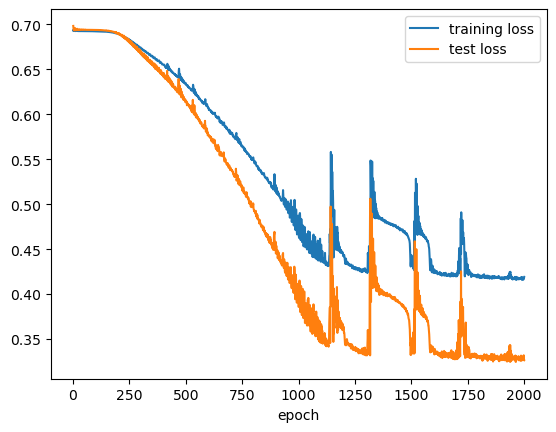

In [ ]:

n_epochs = 2000
print_every = 10
train_losses = []
test_losses = []

train_losses, test_losses = train(rnn_model, X_train, y_train, X_test, y_test, 
          loss_fn, optimizer, train_losses, test_losses, n_epochs, print_every)


plot_train_and_test_loss(train_losses, test_losses)

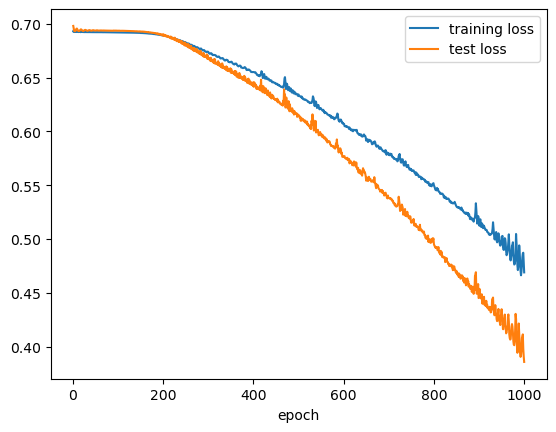

In [172]:
plot_train_and_test_loss(train_losses, test_losses)

<Figure size 800x500 with 0 Axes>

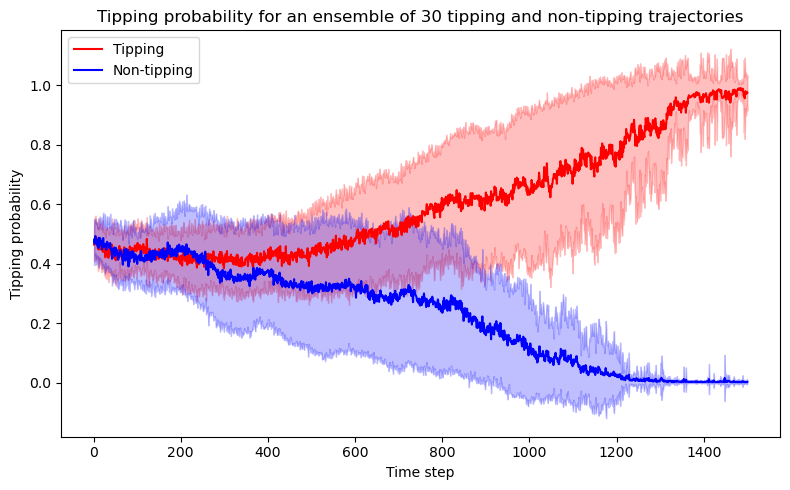

In [252]:
plot_model_on_test(rnn_model, X_test, y_test, n_plots=30, plot_mean=True)

In [ ]:
save_path = os.path.join("PreTrainedModels", "CNN_LSTM_kernel_size=5_hidden_size=50_features=50_model_weights.pth")

torch.save(rnn_model.state_dict(), save_path)

print(f"Model saved to {save_path}")

Model saved to PreTrainedModels/CNN_LSTM_kernel_size=5_hidden_size=50_features=50_model_weights.pth
